In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [4]:
df = pd.read_csv("../data/benin-malanville.csv")
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      525600 non-null  object 
 1   GHI            525600 non-null  float64
 2   DNI            525600 non-null  float64
 3   DHI            525600 non-null  float64
 4   ModA           525600 non-null  float64
 5   ModB           525600 non-null  float64
 6   Tamb           525600 non-null  float64
 7   RH             525600 non-null  float64
 8   WS             525600 non-null  float64
 9   WSgust         525600 non-null  float64
 10  WSstdev        525600 non-null  float64
 11  WD             525600 non-null  float64
 12  WDstdev        525600 non-null  float64
 13  BP             525600 non-null  int64  
 14  Cleaning       525600 non-null  int64  
 15  Precipitation  525600 non-null  float64
 16  TModA          525600 non-null  float64
 17  TModB          525600 non-nul

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


### 1. Summary Statistics & Missing-Value Report

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
GHI,525600.0,240.559452,331.131327,-12.9,-2.0,1.8,483.4,1413.0
DNI,525600.0,167.187516,261.710501,-7.8,-0.5,-0.1,314.2,952.3
DHI,525600.0,115.358961,158.691074,-12.6,-2.1,1.6,216.3,759.2
ModA,525600.0,236.589496,326.894859,0.0,0.0,4.5,463.7,1342.3
ModB,525600.0,228.883576,316.536515,0.0,0.0,4.3,447.9,1342.3
Tamb,525600.0,28.179683,5.924297,11.0,24.2,28.0,32.3,43.8
RH,525600.0,54.487969,28.073069,2.1,28.8,55.1,80.1,100.0
WS,525600.0,2.121113,1.603466,0.0,1.0,1.9,3.1,19.5
WSgust,525600.0,2.809195,2.029120,0.0,1.3,2.6,4.1,26.6
WSstdev,525600.0,0.473390,0.273395,0.0,0.4,0.5,0.6,4.2


In [ ]:
na_counts = df.isna().sum().sort_values(ascending=False)
na_counts[na_counts > 0]

Comments    525600
dtype: int64

In [16]:

# list cols with >5% nulls
pct_null = (df.isna().mean() * 100).round(2)
pct_null[pct_null > 5]

Comments    100.0
dtype: float64

In [ ]:
df.drop(columns=['Comments'], inplace=True)


### 2. Outlier detection & basic cleaning

In [29]:
# 2. Z-score flagging
cols_to_z = ['GHI','DNI','DHI','ModA','ModB','WS','WSgust']

z_scores = df[cols_to_z].apply(lambda x: np.abs(stats.zscore(x.dropna())), axis=0)
# Because applying stats.zscore directly on df with NaNs is tricky, compute per-col:
outlier_flags = pd.DataFrame(False, index=df.index, columns=cols_to_z)
for c in cols_to_z:
    col = df[c]
    # mask NaN to avoid warnings
    zs = (col - col.mean())/col.std(ddof=0)
    outlier_flags[c] = zs.abs() > 3

# summary of flagged rows
df['outlier_any'] = outlier_flags.any(axis=1)

df['outlier_any'].sum(), df['outlier_any'].mean()



(np.int64(5735), np.float64(0.01099103277378404))

In [33]:

# Imputation strategy: median for key numeric columns
key_cols = ['GHI','DNI','DHI','ModA','ModB','Tamb','RH','WS','WSgust']
for c in key_cols:
    if c in df.columns:
        median_val = df[c].median()
        df[c] = df[c].fillna(median_val)


In [35]:
# Optionally drop extreme outliers (or keep but mark them)

# # Example: drop rows where outlier_any True for critical irradiance cols
mask_out = df['outlier_any'] & (outlier_flags[['GHI','DNI','DHI']].any(axis=1))
print("Dropping", mask_out.sum(), "rows due to extreme irradiance outliers")
df = df.loc[~mask_out].copy()

Dropping 0 rows due to extreme irradiance outliers


In [36]:
df['outlier_any'].sum(), df['outlier_any'].mean()

(np.int64(3914), np.float64(0.007527386300695427))

In [37]:
df.to_csv('../data/benin_clean.csv', index=False)

### 3. Time series analysis (plots)

In [65]:
df = pd.read_csv('../data/benin_clean.csv')
print(df.describe())
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Optional: set as index
df.set_index('Timestamp', inplace=True)

                 GHI            DNI            DHI           ModA  \
count  519968.000000  519968.000000  519968.000000  519968.000000   
mean      234.461055     166.918450     110.002361     230.818794   
std       327.364733     262.675953     150.871675     323.608215   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.500000      -2.100000       0.000000   
50%         0.300000      -0.100000       0.200000       2.900000   
75%       463.400000     317.400000     209.800000     443.500000   
max      1221.000000     952.300000     571.000000    1266.100000   

                ModB           Tamb             RH             WS  \
count  519968.000000  519968.000000  519968.000000  519968.000000   
mean      223.495393      28.118056      54.671836       2.106324   
std       313.685365       5.911155      28.024312       1.598986   
min         0.000000      11.000000       2.100000       0.000000   
25%         0.000000      24.1000

#### Plot of GHI, DNI, DHI, Tamb over time

d:\DS_Courses\KAIM_10_Academy\KAIM_8\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


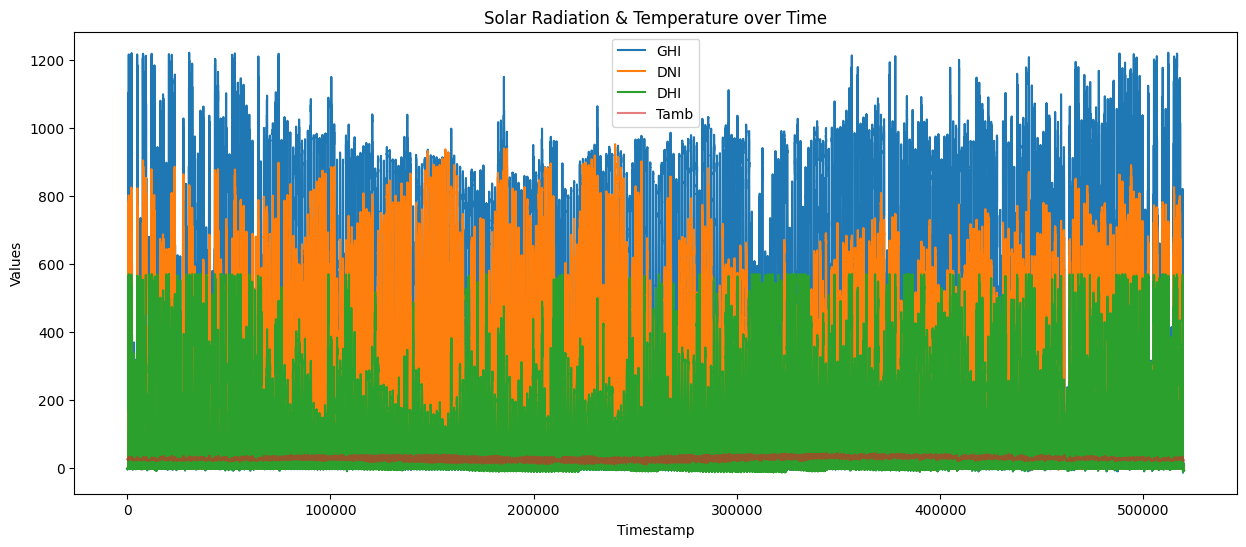

In [47]:
plt.figure(figsize=(15,6))
plt.plot(df['GHI'], label='GHI')
plt.plot(df['DNI'], label='DNI')
plt.plot(df['DHI'], label='DHI')
plt.plot(df['Tamb'], label='Tamb', alpha=0.6)  # ambient temp
plt.title('Solar Radiation & Temperature over Time')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.legend()
plt.show()


#### Bar plot by month

C:\Users\MUHAJER HUALIS\AppData\Local\Temp\ipykernel_14868\2683797394.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('M')[['GHI','DNI','DHI','Tamb']].mean()


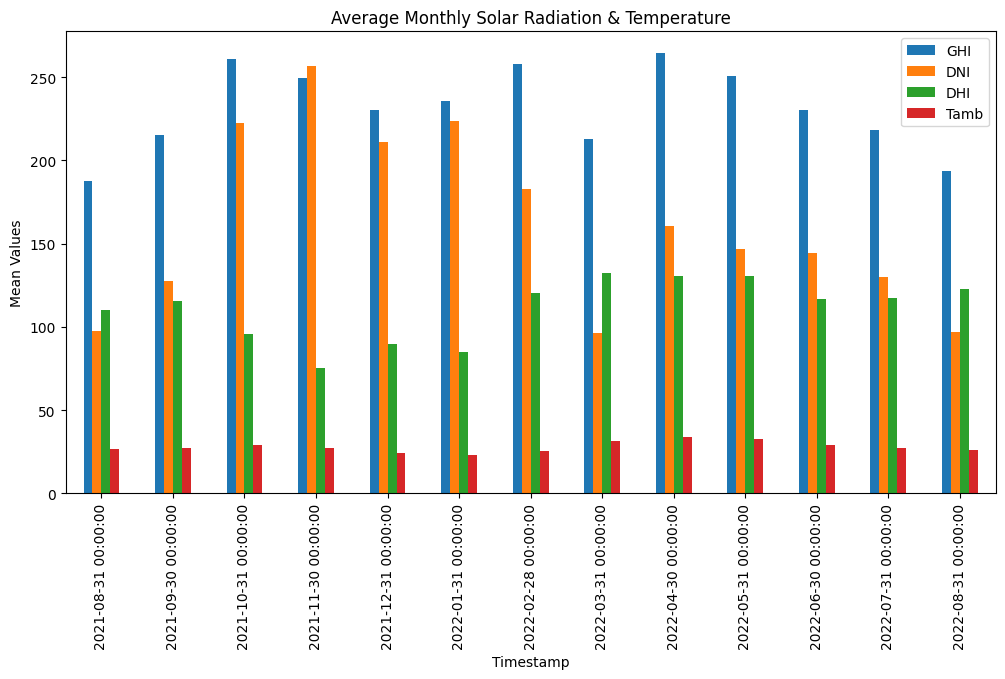

In [50]:
monthly = df.resample('M')[['GHI','DNI','DHI','Tamb']].mean()

monthly.plot(kind='bar', figsize=(12,6))
plt.title('Average Monthly Solar Radiation & Temperature')
plt.ylabel('Mean Values')
plt.show()


#### Daily trend analysis

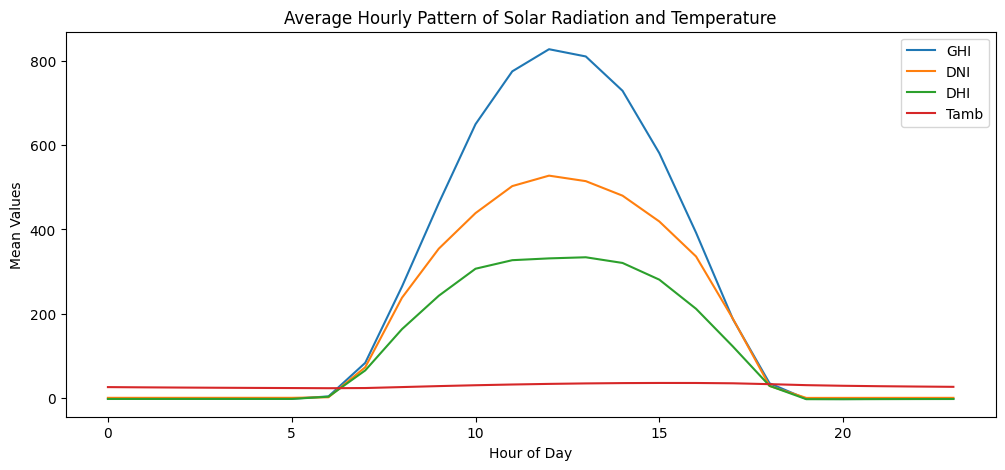

In [51]:
df['Hour'] = df.index.hour
hourly = df.groupby('Hour')[['GHI','DNI','DHI','Tamb']].mean()

hourly.plot(figsize=(12,5))
plt.title('Average Hourly Pattern of Solar Radiation and Temperature')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Values')
plt.show()


#### Cleaning Impact


                ModA        ModB
Cleaning                        
0         230.747456  223.422125
1         307.229278  301.972165


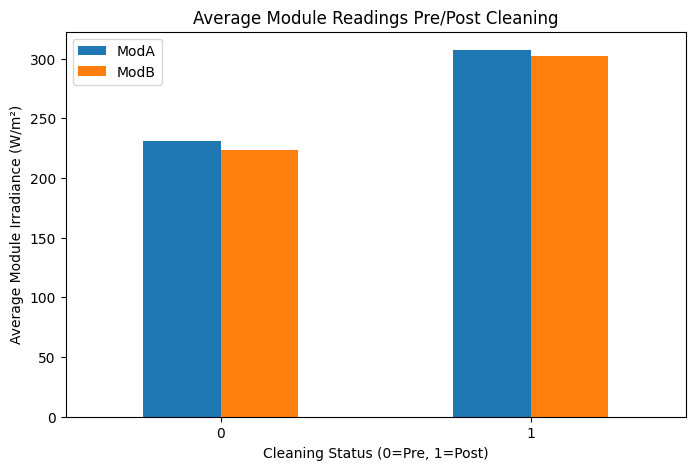

In [54]:
# Compute average Module A and B values for each cleaning status
cleaning_impact = df.groupby('Cleaning')[['ModA','ModB']].mean()
print(cleaning_impact)

cleaning_impact.plot(kind='bar', figsize=(8,5))
plt.title('Average Module Readings Pre/Post Cleaning')
plt.xlabel('Cleaning Status (0=Pre, 1=Post)')
plt.ylabel('Average Module Irradiance (W/m²)')
plt.xticks(rotation=0)
plt.show()

### Correlation & Relationship Analysis

#### Correlation Heatmap (GHI, DNI, DHI, TModA, TModB)

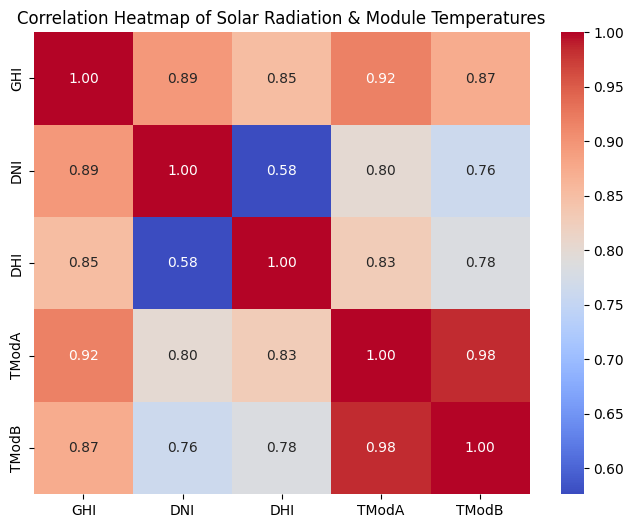

In [56]:
# Select key columns
corr_cols = ['GHI','DNI','DHI','TModA','TModB']

# Compute correlation matrix
corr_matrix = df[corr_cols].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Solar Radiation & Module Temperatures')
plt.show()


#### Scatter Plots for Relationships

##### a) Wind variables vs. GHI

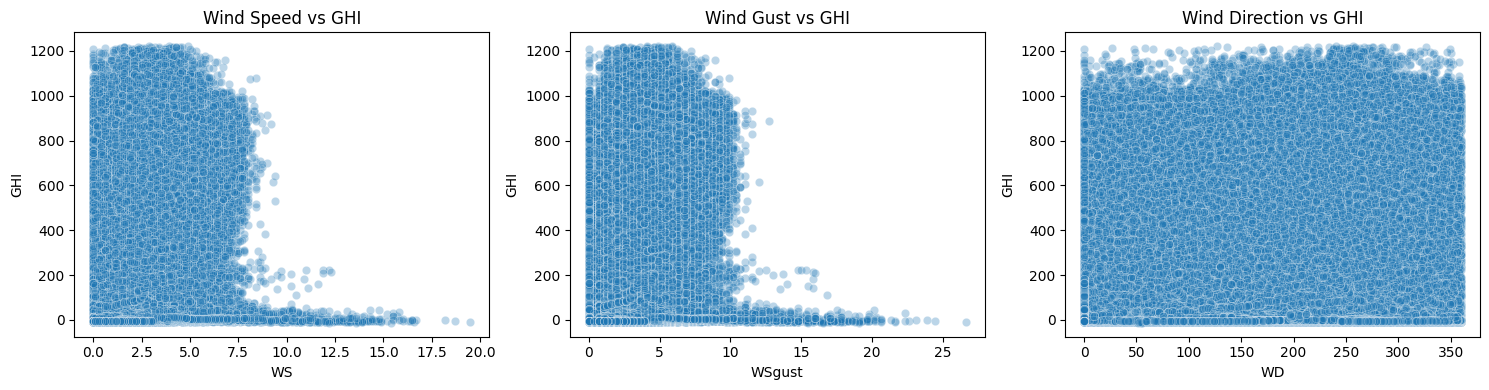

In [57]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.scatterplot(x='WS', y='GHI', data=df, alpha=0.3)
plt.title('Wind Speed vs GHI')

plt.subplot(1,3,2)
sns.scatterplot(x='WSgust', y='GHI', data=df, alpha=0.3)
plt.title('Wind Gust vs GHI')

plt.subplot(1,3,3)
sns.scatterplot(x='WD', y='GHI', data=df, alpha=0.3)
plt.title('Wind Direction vs GHI')

plt.tight_layout()
plt.show()


##### b) RH vs Temperature or GHI

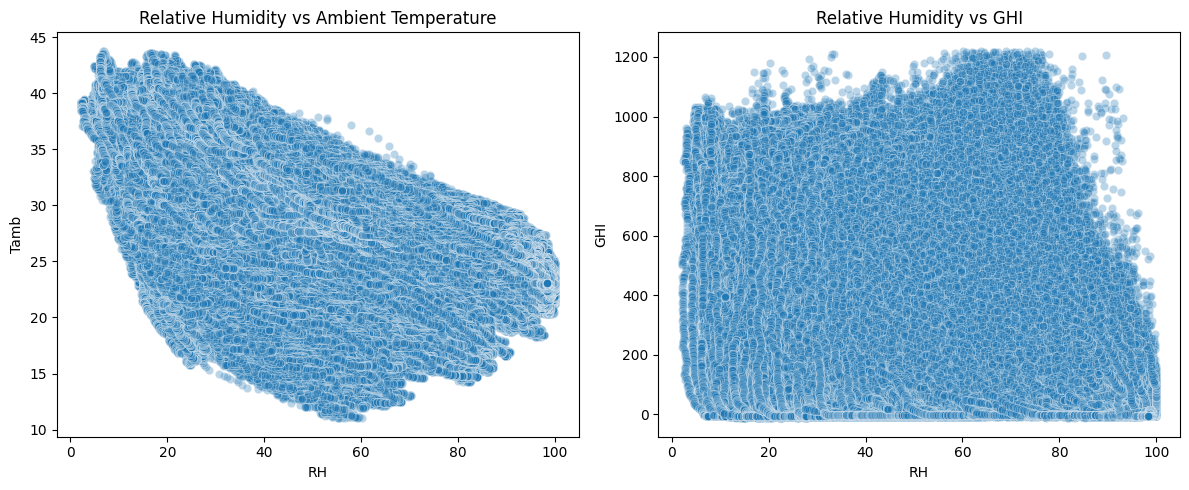

In [58]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.scatterplot(x='RH', y='Tamb', data=df, alpha=0.3)
plt.title('Relative Humidity vs Ambient Temperature')

plt.subplot(1,2,2)
sns.scatterplot(x='RH', y='GHI', data=df, alpha=0.3)
plt.title('Relative Humidity vs GHI')

plt.tight_layout()
plt.show()


#### Wind & Distribution Analysis


##### Wind Rose / Radial Plot (WS vs WD)

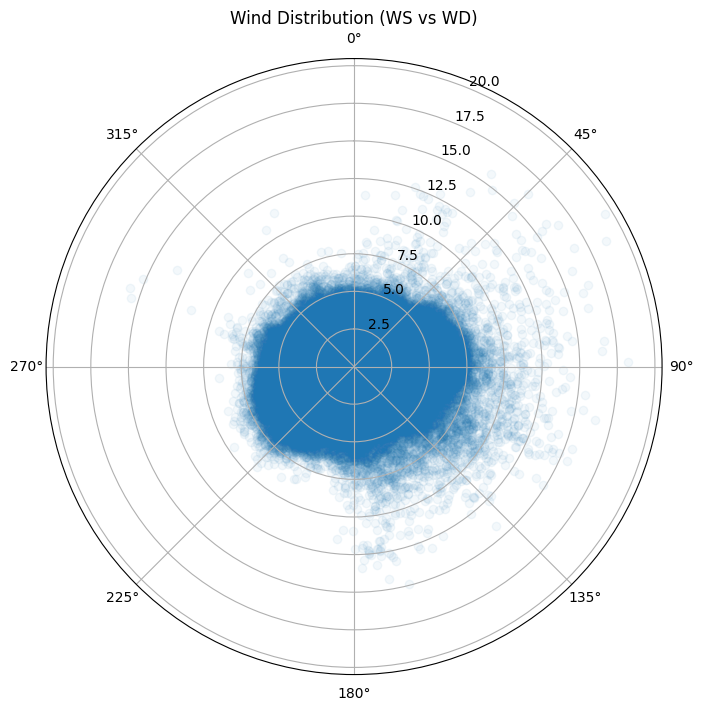

In [59]:

# Convert degrees to radians
wd_rad = np.deg2rad(df['WD'])
ws = df['WS']

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
ax.scatter(wd_rad, ws, alpha=0.05)  # semi-transparent
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
plt.title('Wind Distribution (WS vs WD)')
plt.show()


##### Histograms for GHI and another variable (e.g., WS)

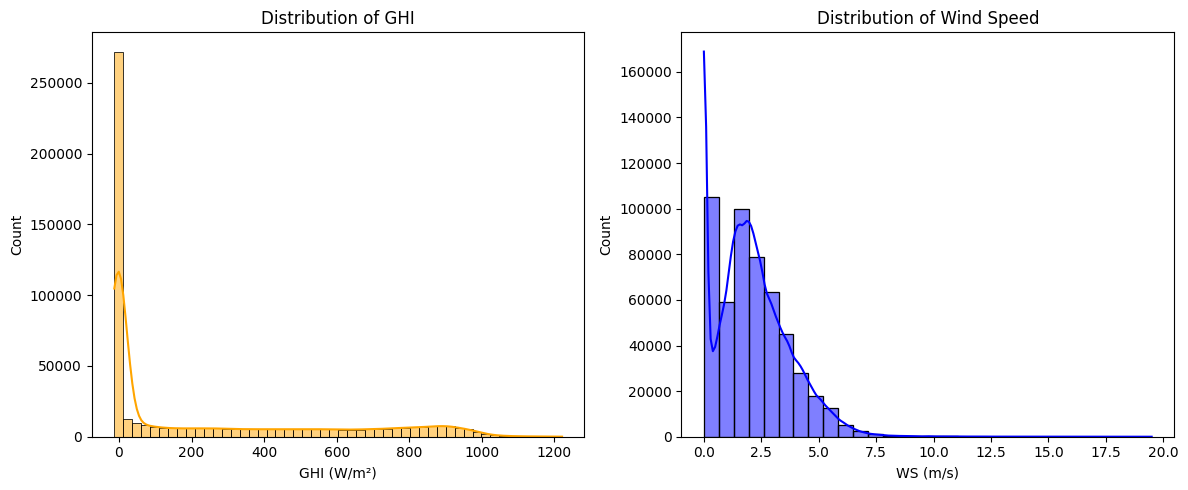

In [60]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(df['GHI'], bins=50, kde=True, color='orange')
plt.title('Distribution of GHI')
plt.xlabel('GHI (W/m²)')

plt.subplot(1,2,2)
sns.histplot(df['WS'], bins=30, kde=True, color='blue')
plt.title('Distribution of Wind Speed')
plt.xlabel('WS (m/s)')

plt.tight_layout()
plt.show()


#### Temperature Analysis


##### Scatter Plot: RH vs Ambient Temperature

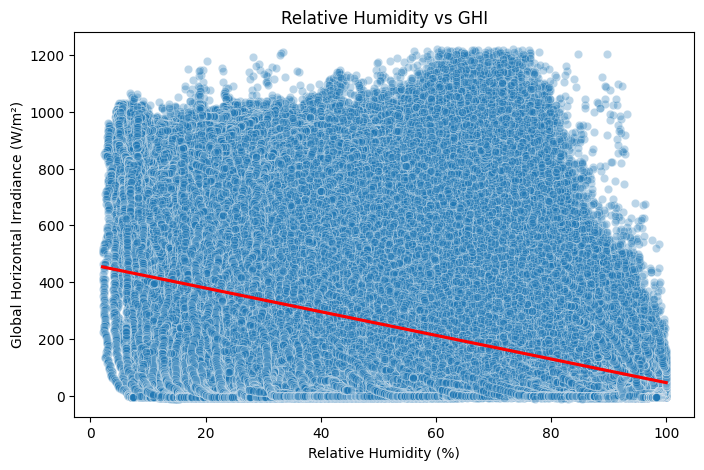

In [61]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='RH', y='GHI', data=df, alpha=0.3)
sns.regplot(x='RH', y='GHI', data=df, scatter=False, color='red')
plt.title('Relative Humidity vs GHI')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.show()


##### Scatter Plot: RH vs Solar Irradiance (GHI)

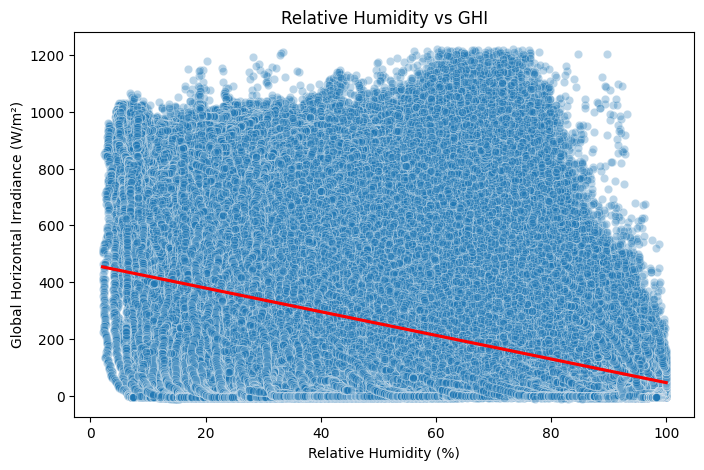

In [62]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='RH', y='GHI', data=df, alpha=0.3)
sns.regplot(x='RH', y='GHI', data=df, scatter=False, color='red')
plt.title('Relative Humidity vs GHI')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.show()


#### Bubble Chart

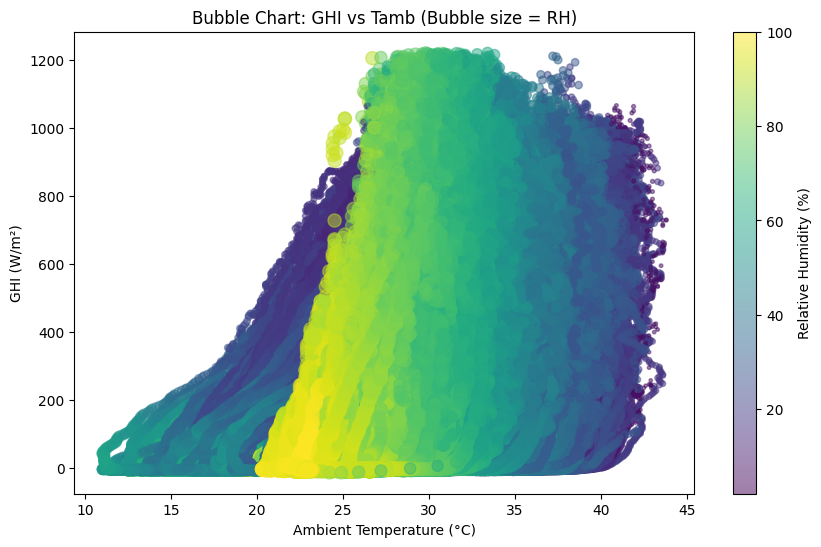

In [63]:

plt.figure(figsize=(10,6))
plt.scatter(
    df['Tamb'],       # x-axis: Ambient Temperature
    df['GHI'],        # y-axis: Global Horizontal Irradiance
    s=df['RH'],       # bubble size proportional to Relative Humidity
    alpha=0.5,
    c=df['RH'],       # optional: color by RH
    cmap='viridis'
)
plt.colorbar(label='Relative Humidity (%)')
plt.title('Bubble Chart: GHI vs Tamb (Bubble size = RH)')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.show()


##### Bubble size = Barometric Pressure (BP)

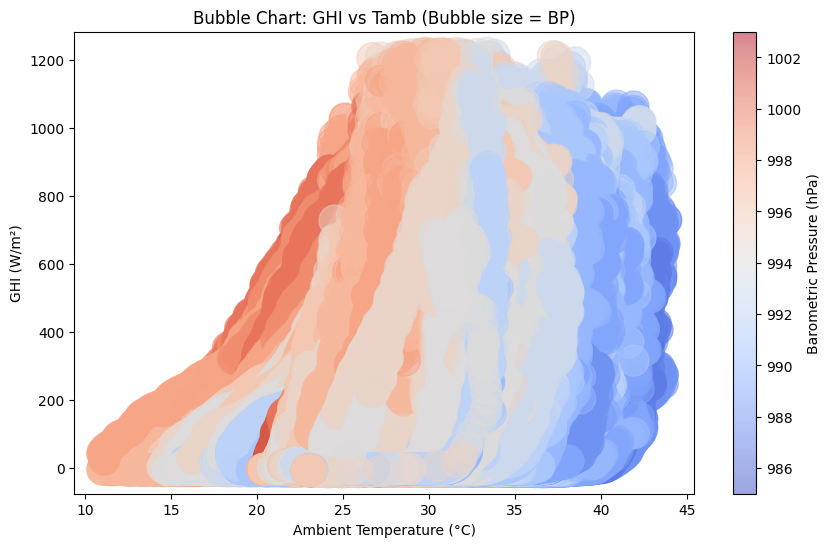

In [64]:
plt.figure(figsize=(10,6))
plt.scatter(
    df['Tamb'],
    df['GHI'],
    s=df['BP']/2,     # scale down BP for bubble size
    alpha=0.5,
    c=df['BP'],
    cmap='coolwarm'
)
plt.colorbar(label='Barometric Pressure (hPa)')
plt.title('Bubble Chart: GHI vs Tamb (Bubble size = BP)')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.show()
